# ⚛️ H₂ VQE — Noise Scans, ΔE Shifts & Fidelity Behaviour

This notebook explores how **noise** affects the **Variational Quantum Eigensolver (VQE)**.

It follows the standard structure used throughout the H₂ folder:

---

## **🧩 Part 1 — Manual Noisy VQE (Educational)**
Demonstrates explicitly:

- How noise channels enter a QNode  
- How a simple ansatz behaves under noise  
- A minimal optimisation loop  

This is for intuition only.

---

## **🟦 Part 2 — Package-Level Noise Sweeps (Production Workflow)**

Uses your VQE engine:

- `run_vqe`  
- `run_vqe_noise_sweep`  
- `run_vqe_multi_seed_noise`  

to generate:

- ΔE vs noise  
- Fidelity vs noise  
- Multi-seed statistics  

All caching, plotting, and reproducibility are handled automatically.

---

In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.core import (
    run_vqe,
    run_vqe_noise_sweep,
    run_vqe_multi_seed_noise,
)
from vqe_qpe_common.plotting import IMG_DIR

# Manual system setup for the educational demo
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.7414]])

H, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    basis="sto-3g",
)

num_wires = qubits
print(f"H₂ Hamiltonian → {num_wires} qubits")

H₂ Hamiltonian → 4 qubits


# 🧩 Part 1 — Manual Noisy VQE  

This block shows explicitly how noise is inserted into the circuit.

Here we use a **two-parameter variant** of the TwoQubit–RY–CNOT ansatz:

- This is *not* the same as the package's 1-parameter version  
- We keep it here because it is pedagogically clearer  

[demo] Step 01/30 → E = 1.290195 Ha
[demo] Step 02/30 → E = 1.287505 Ha
[demo] Step 03/30 → E = 1.284421 Ha
[demo] Step 04/30 → E = 1.280887 Ha
[demo] Step 05/30 → E = 1.276838 Ha
[demo] Step 06/30 → E = 1.272200 Ha
[demo] Step 07/30 → E = 1.266892 Ha
[demo] Step 08/30 → E = 1.260819 Ha
[demo] Step 09/30 → E = 1.253877 Ha
[demo] Step 10/30 → E = 1.245950 Ha
[demo] Step 11/30 → E = 1.236909 Ha
[demo] Step 12/30 → E = 1.226613 Ha
[demo] Step 13/30 → E = 1.214908 Ha
[demo] Step 14/30 → E = 1.201632 Ha
[demo] Step 15/30 → E = 1.186610 Ha
[demo] Step 16/30 → E = 1.169664 Ha
[demo] Step 17/30 → E = 1.150613 Ha
[demo] Step 18/30 → E = 1.129280 Ha
[demo] Step 19/30 → E = 1.105503 Ha
[demo] Step 20/30 → E = 1.079138 Ha
[demo] Step 21/30 → E = 1.050076 Ha
[demo] Step 22/30 → E = 1.018252 Ha
[demo] Step 23/30 → E = 0.983656 Ha
[demo] Step 24/30 → E = 0.946349 Ha
[demo] Step 25/30 → E = 0.906466 Ha
[demo] Step 26/30 → E = 0.864228 Ha
[demo] Step 27/30 → E = 0.819940 Ha
[demo] Step 28/30 → E = 0.77

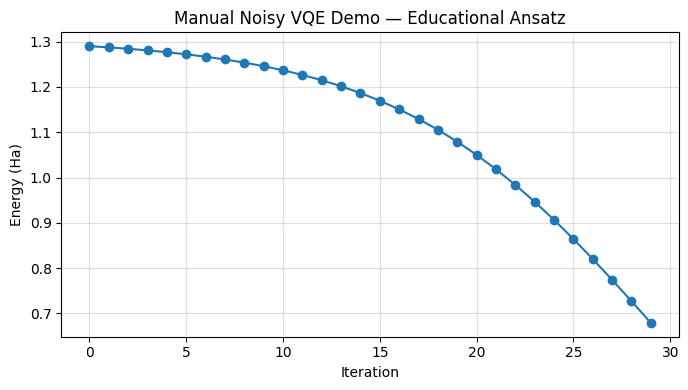

In [2]:
def educational_ansatz(params, wires):
    """Two-parameter RY–CNOT–RY ansatz (educational)."""
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[1], wires=wires[1])

# Noise parameters used only for this demo
p_dep_demo = 0.02
p_amp_demo = 0.04

dev = qml.device("default.mixed", wires=num_wires)

@qml.qnode(dev, diff_method="finite-diff")
def noisy_energy(params):
    educational_ansatz(params, wires=[0, 1])

    # Explicit noise injection
    for w in range(num_wires):
        qml.DepolarizingChannel(p_dep_demo, wires=w)
        qml.AmplitudeDamping(p_amp_demo, wires=w)

    return qml.expval(H)

# Manual VQE loop
opt = qml.GradientDescentOptimizer(stepsize=0.1)
params = 0.1 * np.random.randn(2, requires_grad=True)

energies_demo = []
n_steps_demo = 30

for step in range(n_steps_demo):
    params, _ = opt.step_and_cost(noisy_energy, params)
    e = float(noisy_energy(params))
    energies_demo.append(e)
    print(f"[demo] Step {step+1:02d}/{n_steps_demo} → E = {e:.6f} Ha")

# Plot
plt.figure(figsize=(7, 4))
plt.plot(energies_demo, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("Manual Noisy VQE Demo — Educational Ansatz")
plt.grid(True, alpha=0.4)
plt.tight_layout()

plt.savefig(os.path.join(IMG_DIR, "H2_Manual_Noisy_VQE_Demo.png"), dpi=300)
plt.show()

# 🟦 Part 2 — Noiseless Reference (Package API)

Before running noise sweeps, we compute a **reference VQE solution** using:

```python
run_vqe(...)
```

This provides:
- Final energy  
- Full convergence trace  
- Statevector for fidelity calculations  

In [3]:
ref = run_vqe(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    n_steps=50,
    stepsize=0.2,
    noisy=False,
    plot=False,         # faster
    seed=0,
    force=False,
)

reference_energy = ref["energy"]
reference_state = np.array(ref["final_state_real"]) + 1j * np.array(ref["final_state_imag"])

reference_energy

Step 01/50: E = 0.713580 Ha
Step 02/50: E = 0.675481 Ha
Step 03/50: E = 0.602735 Ha
Step 04/50: E = 0.489734 Ha
Step 05/50: E = 0.350455 Ha
Step 06/50: E = 0.205184 Ha
Step 07/50: E = 0.076243 Ha
Step 08/50: E = -0.026114 Ha
Step 09/50: E = -0.121293 Ha
Step 10/50: E = -0.231641 Ha
Step 11/50: E = -0.361961 Ha
Step 12/50: E = -0.507609 Ha
Step 13/50: E = -0.659197 Ha
Step 14/50: E = -0.804629 Ha
Step 15/50: E = -0.931290 Ha
Step 16/50: E = -1.028511 Ha
Step 17/50: E = -1.089749 Ha
Step 18/50: E = -1.113919 Ha
Step 19/50: E = -1.105657 Ha
Step 20/50: E = -1.074350 Ha
Step 21/50: E = -1.031887 Ha
Step 22/50: E = -0.989672 Ha
Step 23/50: E = -0.956203 Ha
Step 24/50: E = -0.936165 Ha
Step 25/50: E = -0.930865 Ha
Step 26/50: E = -0.939184 Ha
Step 27/50: E = -0.958461 Ha
Step 28/50: E = -0.985156 Ha
Step 29/50: E = -1.015347 Ha
Step 30/50: E = -1.045184 Ha
Step 31/50: E = -1.071331 Ha
Step 32/50: E = -1.091371 Ha
Step 33/50: E = -1.104100 Ha
Step 34/50: E = -1.109609 Ha
Step 35/50: E = -1.10

-1.1107277685002392

# 🔬 Part 3 — Single-Seed Noise Scans  

Using:

```python
run_vqe_noise_sweep(...)
```

This generates:
- ΔE vs noise  
- Fidelity vs noise  

*Fully cached, fully reproducible.*

Step 01/30: E = 0.713580 Ha
Step 02/30: E = 0.675481 Ha
Step 03/30: E = 0.602735 Ha
Step 04/30: E = 0.489734 Ha
Step 05/30: E = 0.350455 Ha
Step 06/30: E = 0.205184 Ha
Step 07/30: E = 0.076243 Ha
Step 08/30: E = -0.026114 Ha
Step 09/30: E = -0.121293 Ha
Step 10/30: E = -0.231641 Ha
Step 11/30: E = -0.361961 Ha
Step 12/30: E = -0.507609 Ha
Step 13/30: E = -0.659197 Ha
Step 14/30: E = -0.804629 Ha
Step 15/30: E = -0.931290 Ha
Step 16/30: E = -1.028511 Ha
Step 17/30: E = -1.089749 Ha
Step 18/30: E = -1.113919 Ha
Step 19/30: E = -1.105657 Ha
Step 20/30: E = -1.074350 Ha
Step 21/30: E = -1.031887 Ha
Step 22/30: E = -0.989672 Ha
Step 23/30: E = -0.956203 Ha
Step 24/30: E = -0.936165 Ha
Step 25/30: E = -0.930865 Ha
Step 26/30: E = -0.939184 Ha
Step 27/30: E = -0.958461 Ha
Step 28/30: E = -0.985156 Ha
Step 29/30: E = -1.015347 Ha
Step 30/30: E = -1.045184 Ha

💾 Saved run record to /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__8d55b444216f.json

St

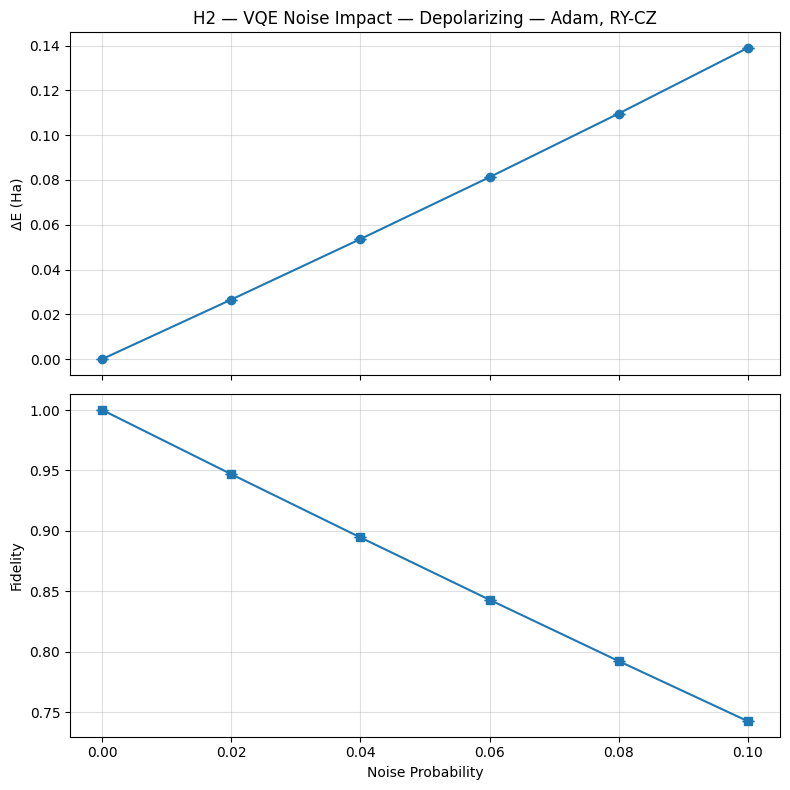


✅ Noise sweep complete for H2 (RY-CZ, Adam)


In [4]:
# Sweep depolarizing noise
run_vqe_noise_sweep(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    depolarizing_probs=np.arange(0.0, 0.11, 0.02),
    amplitude_damping_probs=np.zeros(6),
    mapping="jordan_wigner",
    force=False,
)


📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__8d55b444216f.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__26bb65deacd0.json
Step 01/30: E = 0.713584 Ha
Step 02/30: E = 0.676236 Ha
Step 03/30: E = 0.604861 Ha
Step 04/30: E = 0.493799 Ha
Step 05/30: E = 0.356474 Ha
Step 06/30: E = 0.212400 Ha
Step 07/30: E = 0.083266 Ha
Step 08/30: E = -0.019632 Ha
Step 09/30: E = -0.113008 Ha
Step 10/30: E = -0.219473 Ha
Step 11/30: E = -0.345015 Ha
Step 12/30: E = -0.485802 Ha
Step 13/30: E = -0.633143 Ha
Step 14/30: E = -0.775544 Ha
Step 15/30: E = -0.900786 Ha
Step 16/30: E = -0.998321 Ha
Step 17/30: E = -1.061422 Ha
Step 18/30: E = -1.088550 Ha
Step 19/30: E = -1.083657 Ha
Step 20/30: E = -1.055341 Ha
Step 21/30: E = -1.014815 Ha
Step 22/30: E = -0.973174 Ha
Step 23/30: E = -0.939030 Ha
Step 24/30: E = -0.917457 Ha
Step 25/30: E = -0.910218 Ha
Step 26/30: E = 

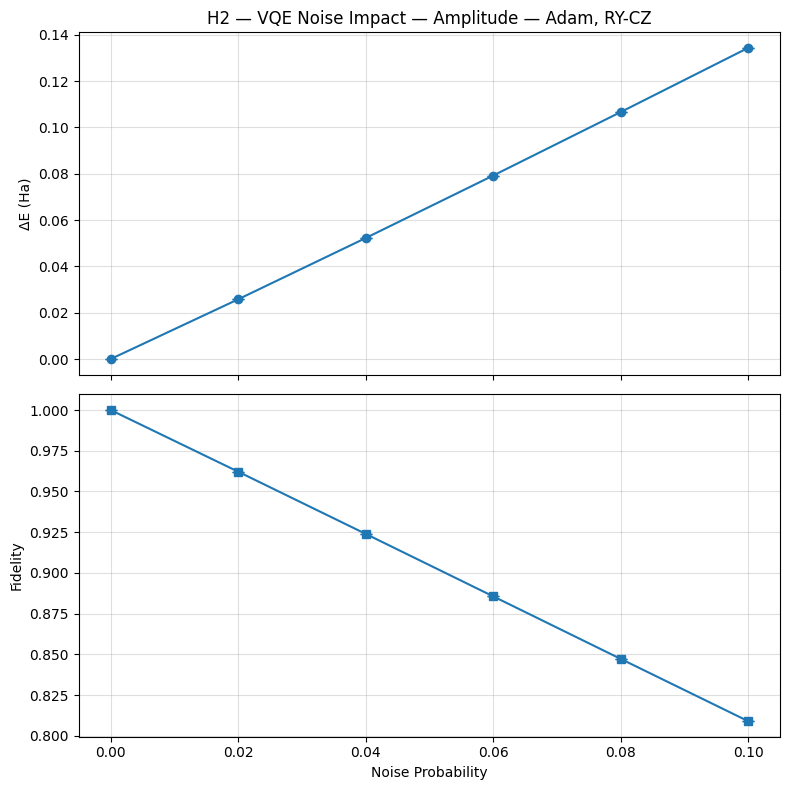


✅ Noise sweep complete for H2 (RY-CZ, Adam)


In [5]:
# Sweep amplitude damping noise
run_vqe_noise_sweep(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    depolarizing_probs=np.zeros(6),
    amplitude_damping_probs=np.arange(0.0, 0.11, 0.02),
    mapping="jordan_wigner",
    force=False,
)

# 📈 Part 4 — Multi-Seed Noise Statistics  

The function:

```python
run_vqe_multi_seed_noise(...)
```

evaluates variability by running VQE across many seeds.


🔹 Computing noiseless reference runs...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__8d55b444216f.json
Step 01/30: E = 0.713643 Ha
Step 02/30: E = 0.676009 Ha
Step 03/30: E = 0.602924 Ha
Step 04/30: E = 0.485968 Ha
Step 05/30: E = 0.336314 Ha
Step 06/30: E = 0.172726 Ha
Step 07/30: E = 0.020335 Ha
Step 08/30: E = -0.097872 Ha
Step 09/30: E = -0.185998 Ha
Step 10/30: E = -0.272948 Ha
Step 11/30: E = -0.372510 Ha
Step 12/30: E = -0.485273 Ha
Step 13/30: E = -0.607519 Ha
Step 14/30: E = -0.733146 Ha
Step 15/30: E = -0.853940 Ha
Step 16/30: E = -0.960236 Ha
Step 17/30: E = -1.042521 Ha
Step 18/30: E = -1.093880 Ha
Step 19/30: E = -1.112456 Ha
Step 20/30: E = -1.102505 Ha
Step 21/30: E = -1.073102 Ha
Step 22/30: E = -1.035102 Ha
Step 23/30: E = -0.998137 Ha
Step 24/30: E = -0.968956 Ha
Step 25/30: E = -0.951199 Ha
Step 26/30: E = -0.945940 Ha
Step 27/30: E = -0.952429 Ha
Step 28/30: E = -0.968715 Ha
Step 29/30: E = -0.

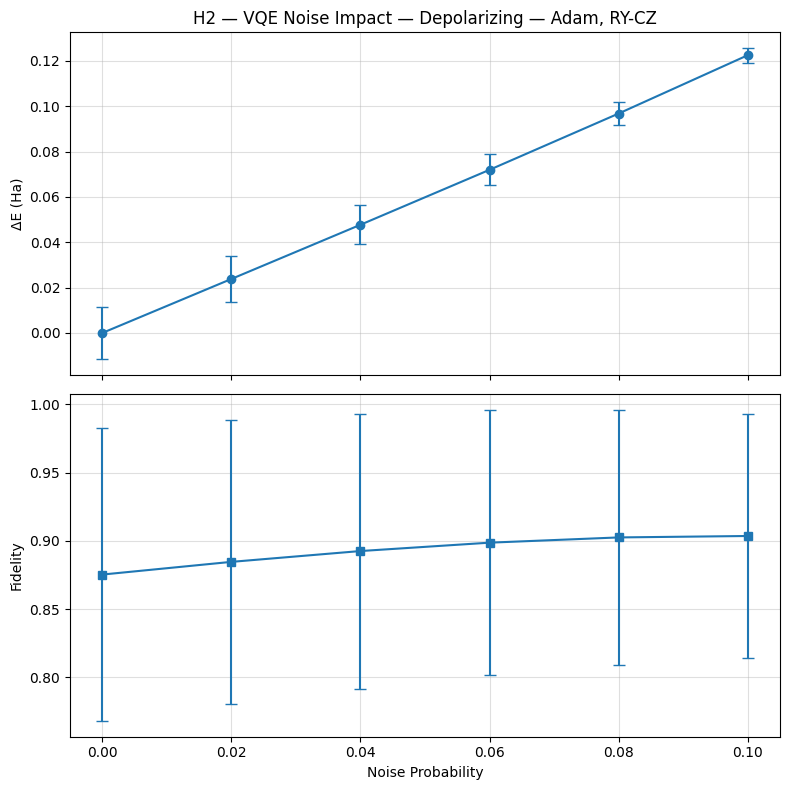


✅ Multi-seed noise study complete for H2


In [6]:
# Multi-seed depolarizing noise
run_vqe_multi_seed_noise(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    stepsize=0.2,
    seeds=np.arange(0, 5),
    noise_type="depolarizing",
    depolarizing_probs=np.arange(0.0, 0.11, 0.02),
    mapping="jordan_wigner",
    force=False,
)


🔹 Computing noiseless reference runs...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__8d55b444216f.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s1__a15b77d60a69.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s2__05ab1c38d644.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s3__8a1117bd5599.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s4__35938dcc584d.json
Reference mean energy = -1.022584 Ha

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s0__26bb65deacd0.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noisy__s1__e74

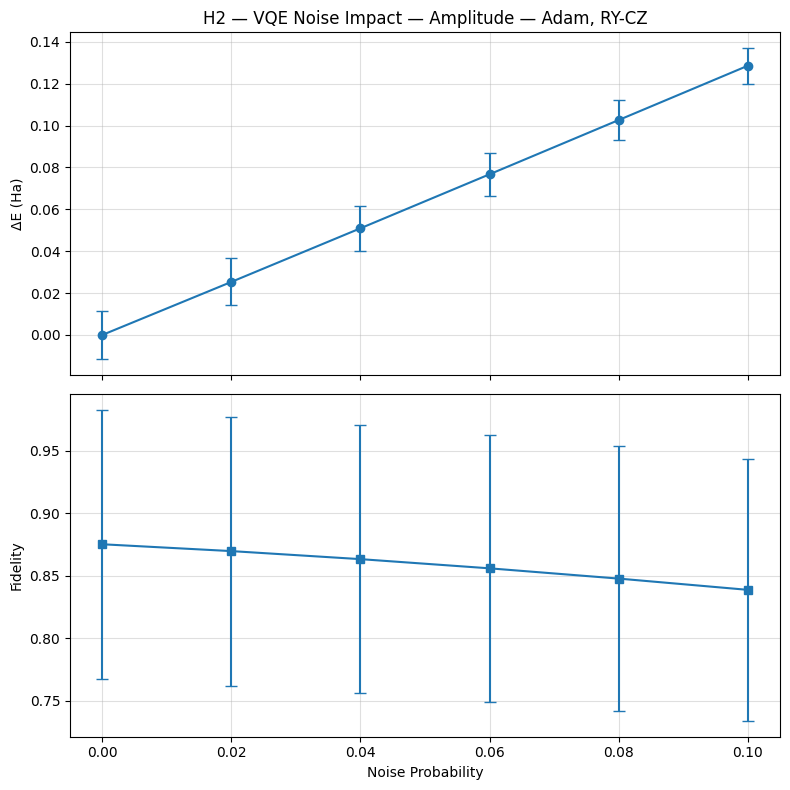


✅ Multi-seed noise study complete for H2


In [7]:
# Multi-seed amplitude damping
run_vqe_multi_seed_noise(
    molecule="H2",
    ansatz_name="RY-CZ",
    optimizer_name="Adam",
    steps=30,
    stepsize=0.2,
    seeds=np.arange(0, 5),
    noise_type="amplitude",
    depolarizing_probs=np.arange(0.0, 0.11, 0.02),  # reused internally
    mapping="jordan_wigner",
    force=False,
)

# ✅ Summary

In this notebook you:

- Built a **manual noisy VQE** to understand circuit-level noise  
- Computed a **noiseless reference** using the production engine  
- Ran **single-seed noise sweeps** (ΔE + Fidelity)  
- Ran **multi-seed statistics** for robustness  

This completes the full H₂ noise-analysis workflow.